In [1]:
import pymc3 as pm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import rpy2.robjects as robjects

### Data

In [2]:
robjects.r['load']("nels.RData")

'Y.school.math...,'y.school1','y.school2'


In [3]:
robjects.r['ls']()[0]

'Y.school.mathscore'

In [4]:
scores = pd.DataFrame(np.array(robjects.r['Y.school.mathscore']), columns=['school', 'score'])
scores['school'] = scores['school'].astype(int)
scores.head()

,school,score
0,1,52.11
1,1,57.65
2,1,66.44
3,1,44.68
4,1,40.57


In [5]:
school_groups = scores.groupby('school')
school_stats = pd.concat([school_groups.count(), school_groups.mean()], axis=1)
school_stats.columns = ['count', 'mean']
school_stats.head()

,count,mean
school,,
1,31,50.813548
2,22,46.479545
3,23,48.776957
4,19,47.316316
5,21,36.582857


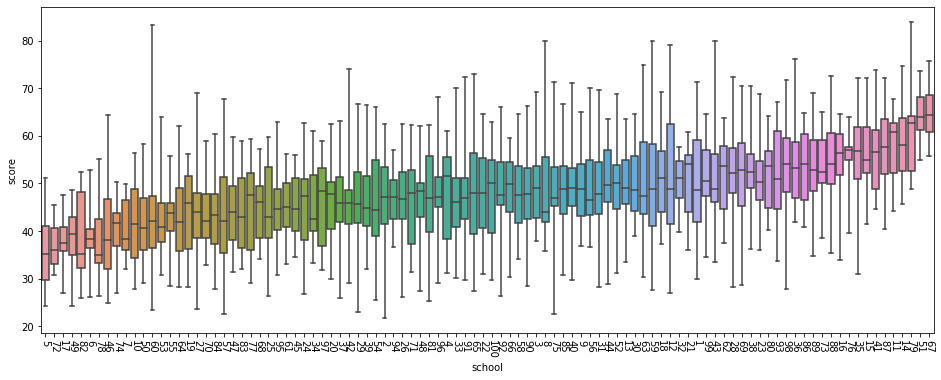

In [6]:
f, ax = plt.subplots(figsize=(16, 6))
sns.boxplot(x="school", y="score", data=scores,
            whis="range", #palette="vlag",
            order=school_stats.sort_values('mean').index)
_ = plt.xticks(rotation=-90)

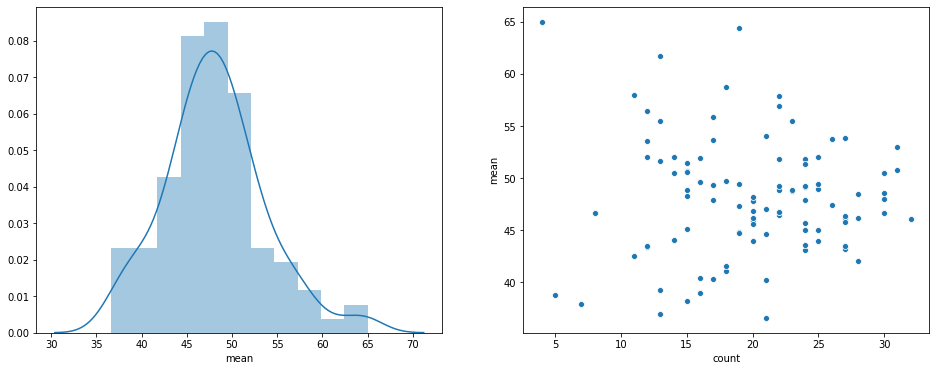

In [77]:
f, axs = plt.subplots(ncols=2, figsize=(16, 6))
sns.distplot(school_stats['mean'], ax=axs[0])
sns.scatterplot(school_stats['count'], school_stats['mean'], ax=axs[1])

In [103]:
scores

,school,score
0,1,52.11
1,1,57.65
2,1,66.44
3,1,44.68
4,1,40.57
...,...,...
1988,100,54.95
1989,100,30.29
1990,100,47.66
1991,100,55.43


In [12]:
scores.groupby('school').to_list()

AttributeError: 'DataFrameGroupBy' object has no attribute 'to_list'

In [22]:
scores_scores = [np.array(scores[scores['school'] == school+1]['score'].tolist()) for school in range(100)]

In [23]:
scores_scores[0]

array([52.11, 57.65, 66.44, 44.68, 40.57, 35.04, 50.71, 66.17, 39.43,
       46.17, 58.76, 47.97, 39.18, 64.63, 69.38, 32.38, 29.98, 59.32,
       43.04, 57.83, 46.07, 47.74, 48.66, 40.8 , 66.32, 53.7 , 52.42,
       71.38, 59.66, 47.52, 39.51])

### Modeling

In [6]:
grand_mean_mean = 50
grand_mean_std = np.sqrt(25)

btwn_sample_size = 1
btwn_std = np.sqrt(100)

within_sample_size = 1
within_std = np.sqrt(100)

In [7]:
with pm.Model() as model:
    grand_mean = pm.Normal('grand_mean', mu=grand_mean_mean, sigma=grand_mean_std)
    
    btwn_std = pm.InverseGamma('btwn_std', alpha=btwn_sample_size/2,
                              beta=btwn_std*btwn_sample_size/2)
    
    btwn_means = pm.Normal('btwn_means', mu=grand_mean, sigma=btwn_std, shape=100)
    
    within_std = pm.InverseGamma('within_std', alpha=within_sample_size/2,
                              beta=within_std*within_sample_size/2)
    
    x = btwn_means[scores['school']-1]
    
    y = pm.Normal('scores', mu=x, sigma=within_std, 
                  observed=scores['score'])
    
    prior = pm.sample_prior_predictive()
    posterior = pm.sample()
    posterior_pred = pm.sample_posterior_predictive(posterior)

/home/mochar/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/mochar/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/mochar/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence 

/home/mochar/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/mochar/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/mochar/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/mochar/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value w

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f815a0abd10>,
      dtype=object)

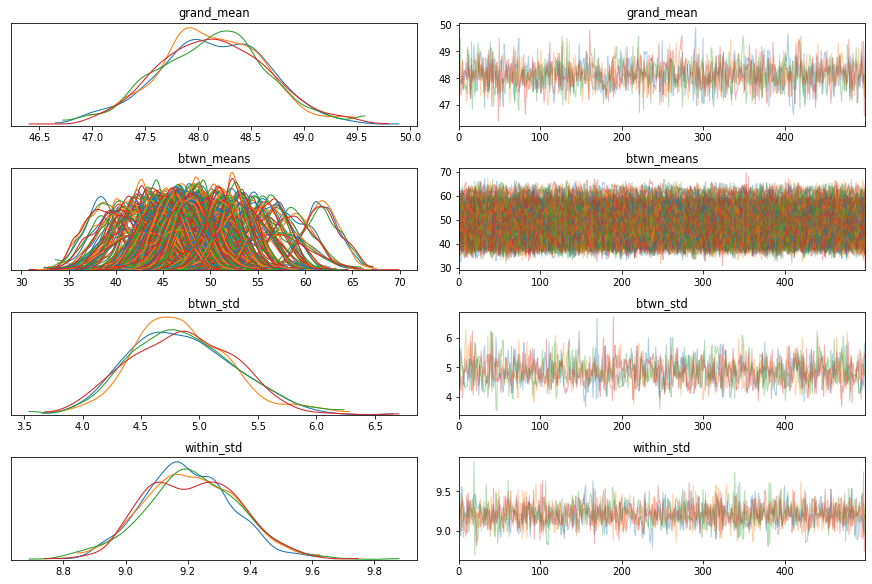

In [8]:
pm.traceplot(posterior)

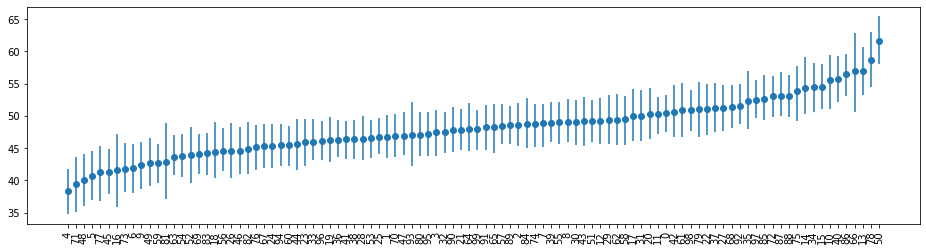

In [15]:
df_hpd = pd.DataFrame(pm.stats.hpd(posterior['btwn_means']),
                      columns=['hpd_low', 'hpd_high'])
                      #index=scores['school'].values)
df_median = pd.DataFrame(np.quantile(posterior['btwn_means'], 0.5, axis=0),
                         columns=['hpd_median'])
                       #  index=scores['school'].values)
df_hpd = df_hpd.join(df_median)
df_hpd['relative_lower'] = df_hpd.hpd_median - df_hpd.hpd_low
df_hpd['relative_upper'] = df_hpd.hpd_high - df_hpd.hpd_median
df_hpd = df_hpd.sort_values(by='hpd_median')
df_hpd = df_hpd.reset_index()
df_hpd['x'] = df_hpd.index + .5


fig, axs = plt.subplots(figsize=(16,4))
axs.errorbar(df_hpd.x, df_hpd.hpd_median,
             yerr=(df_hpd[['relative_lower', 'relative_upper']].values).T,
             fmt='o')
# axs.set_title('HPD of Attack Strength, by Team')
# axs.set_xlabel('Team')
# axs.set_ylabel('Posterior Attack Strength')
_= axs.set_xticks(df_hpd.index + .5)
_= axs.set_xticklabels(df_hpd['index'].values, rotation=90)



In [92]:
prior['scores'].shape

(500, 1993)

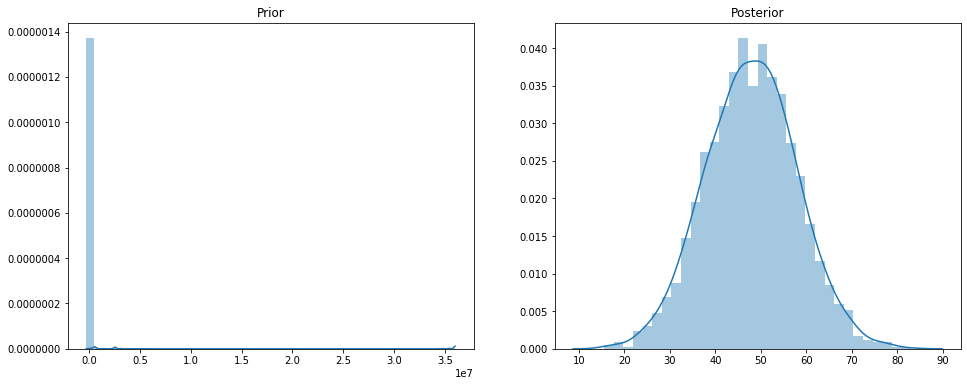

In [101]:
f, axs = plt.subplots(ncols=2, figsize=(16, 6))
axs[0].set_title('Prior')
sns.distplot(prior['scores'][:, -1], ax=axs[0])
axs[1].set_title('Posterior')
sns.distplot(posterior_pred['scores'][:, -1], ax=axs[1])

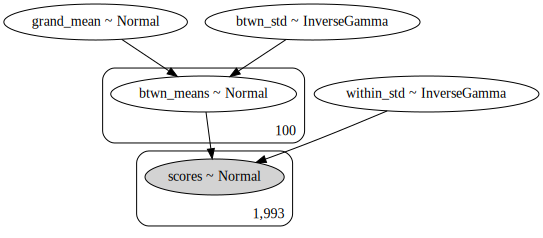

In [9]:
pm.model_to_graphviz(model)

In [ ]:
mochar